**DeepQMC tutorial**
---

**Background:**
---
The ultimate aim of quantum mechanics in chemistry is to provide the most 
probable electronic configuration (electron's position) and to derive the properties from them, all making it possible in simulation. 

The first step to solve this problem is to get an estimate for the wavefunction, whose square gives the electron probability density which can be further used to find the most probable electron position that has the lowest system energy.

The wavefunction for one-electron system like hydrogen can be found exactly by solving the Hamiltonian equation, which becomes a task of solving differential equations, exploiting the property of wavefunction being an eigenfunction. But for complex systems with more atoms and electrons, there will be electron-elctron repulsion terms, inter-nuclear replusion terms, etc, making it more difficult and computationally expensive to calculate the wavefunctions, exactly.

Therefore these systems can be solved via approximation where each orbital (or elctrons) can be aprroximated via a linear combination of determinants called slater determinants.

These systems can be solved via methods like Hartree-Fock or DFT, where the multi-wave electrons are approximated iterations after iteration. But again these methods do not give the wavefunctions accurately and need some after-processing methods. For instance, in Hartree-Fock, electron correlations are completely avoided and further methods like variational monte-carlo are used to improve the wavefucntion.

---

DeepQMC is an implementation of a DNN based variational monte-carlo and here we specifically use the [paulinet](https://arxiv.org/pdf/1909.08423.pdf) ansatz(or the wavefunction). This ansatz aims to add the elctron correlation terms to Hartree-Fock wavefunctions via jastrow and backflow terms, minimizing the energy to find the most accurate wavefunction possible. All this model needs is the positional coordinates of the nucleons and all the training data, i.e the electron's positions are generated on the fly using a Markov chain sampler, using the wavefunction as the probability distribution. Initially, the model is set a base-line of the Hartree-Fock wavefunctions, and later these processing are done to add in electron correlation.

In this tutorial, we will look into how to use DeepQMC using inputs extracted from deepchem's dataset via Rdkit.


# **Colab**
This tutorial and the rest in this sequence can be done in Google colab. If you'd like to open this notebook in colab, you can use the following link.

This tutorial and the rest in this sequence can be done in Google colab. If you'd like to open this notebook in colab, you can use the following link.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/deepchem/deepchem/blob/master/examples/tutorials/DeepQMC_tutorial.ipynb)


**Setup:**

We first install the rdkit which is used to extract nuclear coordinates of the atoms in a molecule from sdf files, which is then loaded into DeepQMC to calculate the energy.

In [ ]:
!pip install rdkit-pypi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 22.7 MB 1.3 MB/s 


In [ ]:
!pip install -U deepqmc[wf,train,cli]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 1.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 98 kB 5.2 MB/s 
     |████████████████████████████████| 96 kB 7.4 MB/s 
     |████████████████████████████████| 37.5 MB 1.2 MB/s 
  Created wheel for deepqmc: filename=deepqmc-0.3.1-py3-none-any.whl size=65279 sha256=39c71efd64d51f518b7a6e5d830590ce9825ba25dd056c32339bc77f058762a1
  Stored in directory: /root/.cache/pip/wheels/d7/4b/e0/591aae685c3c53756116cacf763dd230a46c63dac2cd55b9d6
Successfully built deepqmc
  Attempting uninstall: click
    Found existing installation: click 7.1.2
    Uninstalling click-7.1.2:
      Successfully uninstalled click-7.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This beh

Then here we import padasTools from rdkit, which alows us to represent molecule as a column in a pandas dataframe. Then we import the paulinet ansatz and a custom datastructure called "Molecule", which is used to input 3-D nuclues coordinates.



In [ ]:
from rdkit.Chem import PandasTools

In [ ]:
from deepqmc import Molecule
from deepqmc.wf import PauliNet

Now, we download the sdf file of the Qm-9 dataset, uploaded by deepchem.

In [ ]:
!wget http://deepchem.io.s3-website-us-west-1.amazonaws.com/datasets/gdb7.tar.gz
!tar -zxvf gdb7.tar.gz

--2022-05-29 13:03:28--  http://deepchem.io.s3-website-us-west-1.amazonaws.com/datasets/gdb7.tar.gz
Resolving deepchem.io.s3-website-us-west-1.amazonaws.com (deepchem.io.s3-website-us-west-1.amazonaws.com)... 52.219.120.203
Connecting to deepchem.io.s3-website-us-west-1.amazonaws.com (deepchem.io.s3-website-us-west-1.amazonaws.com)|52.219.120.203|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1560490 (1.5M) [application/x-gzip]
Saving to: ‘gdb7.tar.gz’

gdb7.tar.gz         100%[===================>]   1.49M  4.81MB/s    in 0.3s    

2022-05-29 13:03:28 (4.81 MB/s) - ‘gdb7.tar.gz’ saved [1560490/1560490]

gdb7.sdf
gdb7.sdf.csv


Here, we aim to load the sdf file into a pandas dataframe and view it. As, you can see below.

In [ ]:
SDFFile = "./gdb7.sdf"
BRDLigs = PandasTools.LoadSDF(SDFFile)


,ID,ROMol
0,gdb7k_0000.xyz,
1,gdb7k_0001.xyz,
2,gdb7k_0002.xyz,
3,gdb7k_0003.xyz,
4,gdb7k_0004.xyz,
...,...,...
7164,gdb7k_7160.xyz,
7165,gdb7k_7161.xyz,
7166,gdb7k_7162.xyz,
7167,gdb7k_7163.xyz,

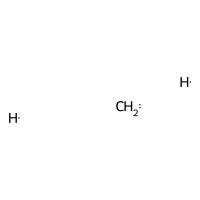
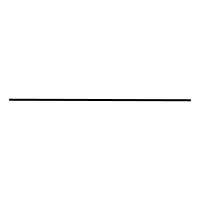
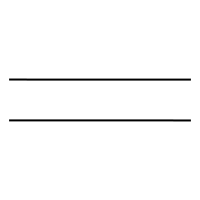
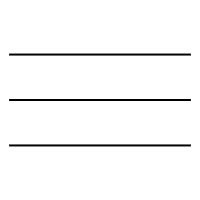
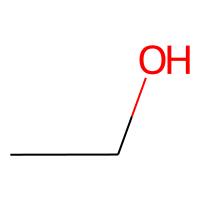
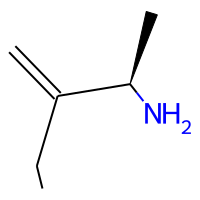
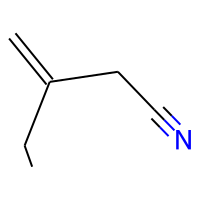
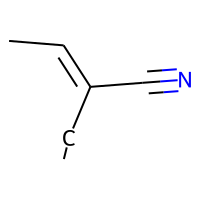
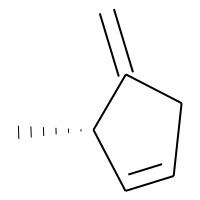
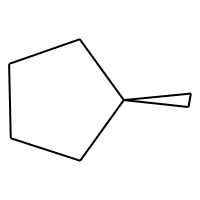

In [ ]:
BRDLigs

Now, lets take an example where we see how to load a specific compound. Let's take the compound number 2, i.e ethane from qm9 and get its x,y and z coordinate.

In [ ]:
from rdkit import Chem
from rdkit.Chem import AllChem
sdf = 'gdb7.sdf'
supplier = Chem.SDMolSupplier(sdf, True, False)
mol = supplier[1] #As ethane is second molecule
smiles=Chem.MolToSmiles(mol)
atom=[]
position=[]

#each atom in the molecule is iterated
for i in mol.GetAtoms():
  pos=mol.GetConformer().GetAtomPosition(i.GetIdx())
  atom.append(i.GetAtomicNum()) #atomic number of the present atom being iterated gets appended
  position.append([pos.x,pos.y,pos.z]) #x,y,z coordinates respectively of the atom appended in the list above

In [ ]:
smiles #now lets output the smile and check

'[H]C([H])([H])C([H])([H])[H]'

In [ ]:
atom #each item in this list corresponds to the corresponding atomic number

[6, 6, 1, 1, 1, 1, 1, 1]

In [ ]:
position

[[1.0041, -0.0029, -0.0064],
 [2.516, -0.007, 0.0006],
 [0.6224, 1.0224, -0.0016],
 [0.6141, -0.5197, 0.8756],
 [0.6224, -0.5084, -0.8986],
 [2.8977, 0.5021, 0.8906],
 [2.9059, 0.5061, -0.8836],
 [2.8976, -1.0324, 0.0001]]

Now, we create our own custom 'Molecule dataset' as shown below. The charge and spin of the atom should be entered accordingly along with the coordinates and charges(the atomic number).

In [ ]:
mol = Molecule(  # C2H6
    coords=position,
    charges=atom,
    charge=0,
    spin=0,
)

Here as we initialize a Paulinet ansatz and feed in the molecule, then we train it, but due it being an 18 electron system, it requires more computation and you are very welcome to go and try it, if you have got the resources!!

In [ ]:
net = PauliNet.from_hf(mol).cuda()


converged SCF energy = -38.6769016473772
CASSCF energy = -38.8215272839933
CASCI E = -38.8215272839933  E(CI) = -1.0317421131881  S^2 = 2.0000000


/usr/local/lib/python3.7/dist-packages/deepqmc/wf/paulinet/paulinet.py:271: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  for n_dbl, cfs in zip(ns_dbl, confs)
Reducing cusp-correction cutoffs due to overlaps


In [ ]:
from deepqmc import train
train(net)

equilibrating: 0it [00:00, ?it/s]

training:   0%|          | 0/10000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/cuda/memory.py:274: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  FutureWarning)


sampling:   0%|          | 0/500 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

# **The Hydrogen Molecule**
In this section, let us look at a simple molecule to compute for, but which cannot be again computed using the simple hamiltonian equation. That is the Hydrogen molecule (2 electrons and 2 nucleus containg each 1 proton).

DeepQMC has already has pre-loaded geometries for the following molecules.

In [ ]:
Molecule.all_names

NameError: ignored

Now lets load the molecule and train as we did before

In [ ]:
from deepqmc import train
mol = Molecule.from_name('H2')
net = PauliNet.from_hf(mol, cas=(4, 2)).cuda()
train(net)


converged SCF energy = -1.12796226856746
CASSCF energy = -1.15328988612271
CASCI E = -1.15328988612271  E(CI) = -1.86646674396978  S^2 = 0.0000000


/usr/local/lib/python3.7/dist-packages/deepqmc/wf/paulinet/paulinet.py:271: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  for n_dbl, cfs in zip(ns_dbl, confs)
Reducing cusp-correction cutoffs due to overlaps


equilibrating: 0it [00:00, ?it/s]

training:   0%|          | 0/10000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/cuda/memory.py:274: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  FutureWarning)


sampling:   0%|          | 0/500 [00:00<?, ?it/s]

sampling:   0%|          | 0/500 [00:00<?, ?it/s]

sampling:   0%|          | 0/500 [00:00<?, ?it/s]

sampling:   0%|          | 0/500 [00:00<?, ?it/s]

sampling:   0%|          | 0/500 [00:00<?, ?it/s]

sampling:   0%|          | 0/500 [00:00<?, ?it/s]

sampling:   0%|          | 0/500 [00:00<?, ?it/s]

sampling:   0%|          | 0/500 [00:00<?, ?it/s]

sampling:   0%|          | 0/500 [00:00<?, ?it/s]

sampling:   0%|          | 0/500 [00:00<?, ?it/s]

sampling:   0%|          | 0/500 [00:00<?, ?it/s]

sampling:   0%|          | 0/500 [00:00<?, ?it/s]

sampling:   0%|          | 0/500 [00:00<?, ?it/s]

sampling:   0%|          | 0/500 [00:00<?, ?it/s]

sampling:   0%|          | 0/500 [00:00<?, ?it/s]

sampling:   0%|          | 0/500 [00:00<?, ?it/s]

sampling:   0%|          | 0/500 [00:00<?, ?it/s]

sampling:   0%|          | 0/500 [00:00<?, ?it/s]

sampling:   0%|          | 0/500 [00:00<?, ?it/s]

sampling:   0%|          | 0/500 [00:00<?, ?it/s]

sampling:   0%|          | 0/500 [00:00<?, ?it/s]

sampling:   0%|          | 0/500 [00:00<?, ?it/s]

sampling:   0%|          | 0/500 [00:00<?, ?it/s]

sampling:   0%|          | 0/500 [00:00<?, ?it/s]

sampling:   0%|          | 0/500 [00:00<?, ?it/s]

sampling:   0%|          | 0/500 [00:00<?, ?it/s]

sampling:   0%|          | 0/500 [00:00<?, ?it/s]

sampling:   0%|          | 0/500 [00:00<?, ?it/s]

sampling:   0%|          | 0/500 [00:00<?, ?it/s]

sampling:   0%|          | 0/500 [00:00<?, ?it/s]

sampling:   0%|          | 0/500 [00:00<?, ?it/s]

sampling:   0%|          | 0/500 [00:00<?, ?it/s]

sampling:   0%|          | 0/500 [00:00<?, ?it/s]

sampling:   0%|          | 0/500 [00:00<?, ?it/s]

sampling:   0%|          | 0/500 [00:00<?, ?it/s]

sampling:   0%|          | 0/500 [00:00<?, ?it/s]

sampling:   0%|          | 0/500 [00:00<?, ?it/s]

sampling:   0%|          | 0/500 [00:00<?, ?it/s]

sampling:   0%|          | 0/500 [00:00<?, ?it/s]

sampling:   0%|          | 0/500 [00:00<?, ?it/s]

sampling:   0%|          | 0/500 [00:00<?, ?it/s]

sampling:   0%|          | 0/500 [00:00<?, ?it/s]

sampling:   0%|          | 0/500 [00:00<?, ?it/s]

sampling:   0%|          | 0/500 [00:00<?, ?it/s]

sampling:   0%|          | 0/500 [00:00<?, ?it/s]

sampling:   0%|          | 0/500 [00:00<?, ?it/s]

sampling:   0%|          | 0/500 [00:00<?, ?it/s]

sampling:   0%|          | 0/500 [00:00<?, ?it/s]

sampling:   0%|          | 0/500 [00:00<?, ?it/s]

sampling:   0%|          | 0/500 [00:00<?, ?it/s]

sampling:   0%|          | 0/500 [00:00<?, ?it/s]

sampling:   0%|          | 0/500 [00:00<?, ?it/s]

sampling:   0%|          | 0/500 [00:00<?, ?it/s]

sampling:   0%|          | 0/500 [00:00<?, ?it/s]

sampling:   0%|          | 0/500 [00:00<?, ?it/s]

sampling:   0%|          | 0/500 [00:00<?, ?it/s]

sampling:   0%|          | 0/500 [00:00<?, ?it/s]

sampling:   0%|          | 0/500 [00:00<?, ?it/s]

sampling:   0%|          | 0/500 [00:00<?, ?it/s]

sampling:   0%|          | 0/500 [00:00<?, ?it/s]

sampling:   0%|          | 0/500 [00:00<?, ?it/s]

sampling:   0%|          | 0/500 [00:00<?, ?it/s]

sampling:   0%|          | 0/500 [00:00<?, ?it/s]

sampling:   0%|          | 0/500 [00:00<?, ?it/s]

sampling:   0%|          | 0/500 [00:00<?, ?it/s]

sampling:   0%|          | 0/500 [00:00<?, ?it/s]

sampling:   0%|          | 0/500 [00:00<?, ?it/s]

sampling:   0%|          | 0/500 [00:00<?, ?it/s]

sampling:   0%|          | 0/500 [00:00<?, ?it/s]

sampling:   0%|          | 0/500 [00:00<?, ?it/s]

sampling:   0%|          | 0/500 [00:00<?, ?it/s]

sampling:   0%|          | 0/500 [00:00<?, ?it/s]

sampling:   0%|          | 0/500 [00:00<?, ?it/s]

sampling:   0%|          | 0/500 [00:00<?, ?it/s]

sampling:   0%|          | 0/500 [00:00<?, ?it/s]

sampling:   0%|          | 0/500 [00:00<?, ?it/s]

sampling:   0%|          | 0/500 [00:00<?, ?it/s]

sampling:   0%|          | 0/500 [00:00<?, ?it/s]

sampling:   0%|          | 0/500 [00:00<?, ?it/s]

sampling:   0%|          | 0/500 [00:00<?, ?it/s]

sampling:   0%|          | 0/500 [00:00<?, ?it/s]

sampling:   0%|          | 0/500 [00:00<?, ?it/s]

sampling:   0%|          | 0/500 [00:00<?, ?it/s]

sampling:   0%|          | 0/500 [00:00<?, ?it/s]

sampling:   0%|          | 0/500 [00:00<?, ?it/s]

sampling:   0%|          | 0/500 [00:00<?, ?it/s]

sampling:   0%|          | 0/500 [00:00<?, ?it/s]

sampling:   0%|          | 0/500 [00:00<?, ?it/s]

sampling:   0%|          | 0/500 [00:00<?, ?it/s]

sampling:   0%|          | 0/500 [00:00<?, ?it/s]

sampling:   0%|          | 0/500 [00:00<?, ?it/s]

sampling:   0%|          | 0/500 [00:00<?, ?it/s]

sampling:   0%|          | 0/500 [00:00<?, ?it/s]

sampling:   0%|          | 0/500 [00:00<?, ?it/s]

sampling:   0%|          | 0/500 [00:00<?, ?it/s]

sampling:   0%|          | 0/500 [00:00<?, ?it/s]

sampling:   0%|          | 0/500 [00:00<?, ?it/s]

sampling:   0%|          | 0/500 [00:00<?, ?it/s]

sampling:   0%|          | 0/500 [00:00<?, ?it/s]

sampling:   0%|          | 0/500 [00:00<?, ?it/s]

Now after training ansatz, we now will evaluate it. Basically, here DeepQMC takes in the trained ansatz and uses a MCMC(Markov-Chain Monte Carlo) sampler to sample electrons and get the average energy for the ansatz trained.

In [ ]:
from deepqmc import evaluate
evaluate(net)

equilibrating: 0it [00:00, ?it/s]

{'energy': -1.1744698901808261+/-2.3497259400603064e-05}

Now as you can see, you have the ground state energy for the hydrogen molecule evaluated!!

As you can see here, this result has a lot of applications!! If you calculate the ground state energy for the hydrogen molecule cation (H2+), then difference in their energy gives you the inoization energy, same can be done if you calculate the hyrogen moleculet anion to calculate the electron affinity, all from doing simulations!! Further, one can also examine the stability of different hypothetical molecule by differing the coordinates of the nucleus of a molecule. Also, the ansatz can also be used to calculate the sample out electrons and calculate electron densities, which can be used to examine various properties like overall size and shape of the molecule (has applications in material sciences and can be used to investigate binding agents for drugs!)

# Congratulations! Time to join the Community!

Congratulations on completing this tutorial notebook! If you enjoyed working through the tutorial, and want to continue working with DeepChem, we encourage you to finish the rest of the tutorials in this series. You can also help the DeepChem community in the following ways:

## Star DeepChem on [GitHub](https://github.com/deepchem/deepchem)
This helps build awareness of the DeepChem project and the tools for open source drug discovery that we're trying to build.

## Join the DeepChem Gitter
The DeepChem [Gitter](https://gitter.im/deepchem/Lobby) hosts a number of scientists, developers, and enthusiasts interested in deep learning for the life sciences. Join the conversation!